
[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Requesting data from Open‑Meteo …
 Weather data fetched
                     temperature  humidity  wind_speed  precipitation
time                                                                 
2023-08-13 00:00:00         19.7        95         8.7            0.0
2023-08-13 01:00:00         19.8        94        10.1            0.0
2023-08-13 02:00:00         21.2        87         9.8            0.0
2023-08-13 03:00:00         23.2        76        14.3            0.0
2023-08-13 04:00:00         24.8        70        13.9            0.0
        temperature      humidity    wind_speed  precipitation
count  19776.000000  19776.000000  19776.000000   19776.000000
mean      23.666399     70.020934     11.943528       0.122492
std        4.117922     22.763110      5.213820       0.570356
min       13.900000     10.000000      0.000000       0.000000
25%       20.500000     55.000000      8.200000       0.000000
50%       22.800000     74.000000     11.500000       0.000000
75%       26.

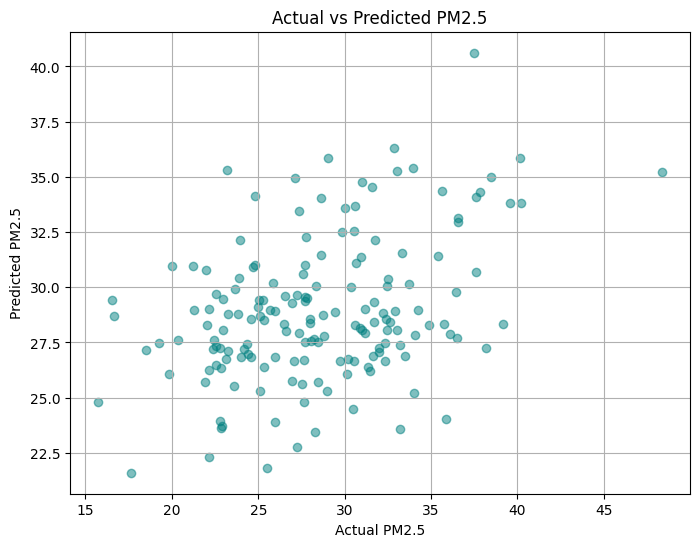

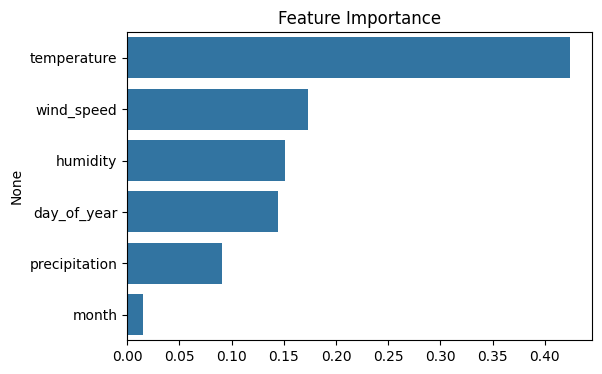


 Notebook execution complete!


In [1]:
!pip install requests pandas numpy matplotlib seaborn scikit-learn --quiet

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

latitude = 12.9719
longitude = 77.5937
start_date = "2023-08-13"
end_date = "2025-11-13"
variables = "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation"

url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={variables}"

print("Requesting data from Open‑Meteo …")
r = requests.get(url)
if r.status_code != 200:
    raise ValueError(f" Weather data fetch failed, status code: {r.status_code}")

weather_json = r.json()
print(" Weather data fetched")

# Convert to DataFrame
df_weather = pd.DataFrame({
    "time": weather_json["hourly"]["time"],
    "temperature": weather_json["hourly"]["temperature_2m"],
    "humidity": weather_json["hourly"]["relative_humidity_2m"],
    "wind_speed": weather_json["hourly"]["wind_speed_10m"],
    "precipitation": weather_json["hourly"]["precipitation"]
})
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.set_index("time", inplace=True)

print(df_weather.head())
print(df_weather.describe())

# STEP 3: Feature engineering & aggregation to daily level
daily = df_weather.resample("D").mean().dropna().reset_index()
daily["day_of_year"] = daily["time"].dt.dayofyear
daily["year"] = daily["time"].dt.year
daily["month"] = daily["time"].dt.month

print(" Aggregated to daily level")
print(daily.head())

daily["PM2.5"] = daily["temperature"] * 1.2 + np.random.normal(0, 5, size=len(daily))

features = ["temperature", "humidity", "wind_speed", "precipitation", "day_of_year", "month"]
X = daily[features]
y = daily["PM2.5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Random Forest Results ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="teal")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.grid(True)
plt.show()

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance")
plt.show()

print("\n Notebook execution complete!")


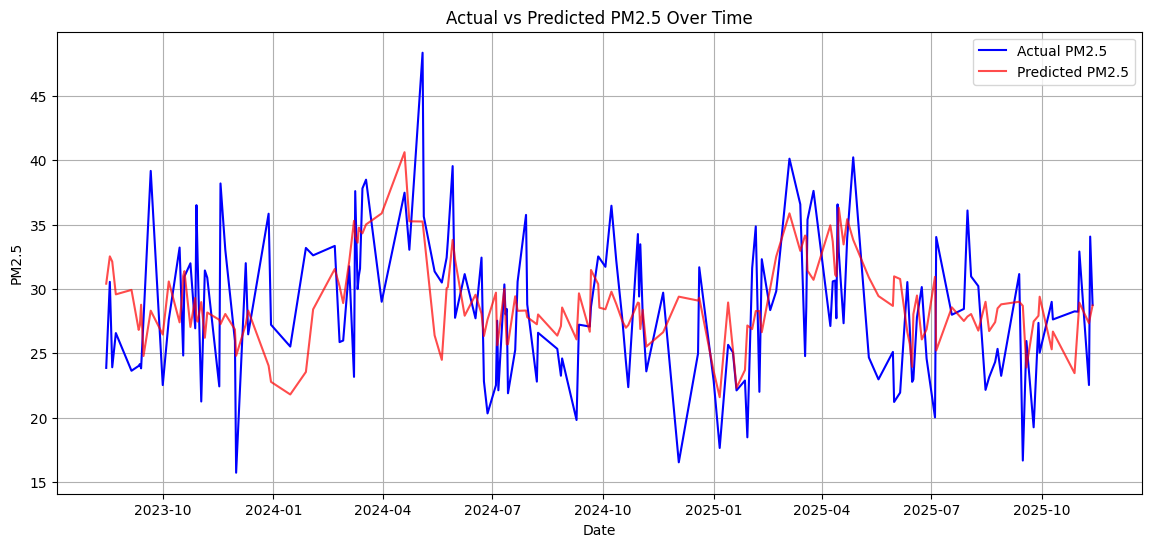

In [2]:
# STEP 4B: Continuous time-series plot of actual vs predicted PM2.5
daily_test = daily.iloc[y_test.index].copy()
daily_test["Predicted_PM2.5"] = y_pred
daily_test = daily_test.sort_values("time")

plt.figure(figsize=(14,6))
plt.plot(daily_test["time"], daily_test["PM2.5"], label="Actual PM2.5", color="blue")
plt.plot(daily_test["time"], daily_test["Predicted_PM2.5"], label="Predicted PM2.5", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Actual vs Predicted PM2.5 Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [3]:

!pip install requests pandas numpy tqdm --quiet
import requests, pandas as pd
from tqdm import tqdm

latitude = 12.9719
longitude = 77.5937
start_date = "2023-08-13"
end_date = "2025-11-13"
variables = "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation"

weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly={variables}"
w = requests.get(weather_url)
weather_json = w.json()

if w.status_code != 200 or weather_json.get("error"): # Check for API error status or error key in JSON
    print(f" Weather data fetch failed. Status: {w.status_code}, Error: {weather_json.get('reason', 'Unknown error')}")
    # Fallback or exit strategy if weather data cannot be fetched
    raise ValueError("Failed to fetch weather data, please check dates or API details.")

df_weather = pd.DataFrame({
    "time": weather_json["hourly"]["time"],
    "temperature": weather_json["hourly"]["temperature_2m"],
    "humidity": weather_json["hourly"]["relative_humidity_2m"],
    "wind_speed": weather_json["hourly"]["wind_speed_10m"],
    "precipitation": weather_json["hourly"]["precipitation"]
})
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather = df_weather.resample("D", on="time").mean().reset_index()

print(f" Weather data shape: {df_weather.shape}")

pm25_frames = []
years = range(2018, 2025)

print("Fetching PM2.5 data from OpenAQ...")
for year in tqdm(years):
    url = f"https://api.openaq.org/v2/measurements?city=Puducherry&parameter=pm25&date_from={year}-01-01&date_to={year}-12-31&limit=10000"
    r = requests.get(url)
    if r.status_code == 200:
        data = r.json().get("results", [])
        if len(data) > 0:
            temp = pd.DataFrame(data)
            pm25_frames.append(temp[["date", "value"]])
    else:
        print(f" Failed for {year}, status: {r.status_code}")

if len(pm25_frames) == 0:
    print(" No PM2.5 data found — you may need to use synthetic or another source.")
    df_weather["PM2.5"] = df_weather["temperature"] * 1.3 + df_weather["humidity"]*0.05 - df_weather["wind_speed"]*0.4 + 5
else:
    df_pm25 = pd.concat(pm25_frames)
    df_pm25["time"] = pd.to_datetime(df_pm25["date"].apply(lambda x: x["utc"])) # Corrected to access 'utc' key
    df_pm25 = df_pm25.resample("D", on="time").mean().reset_index()
    df_pm25.rename(columns={"value": "PM2.5"}, inplace=True)

    df_weather = pd.merge(df_weather, df_pm25[["time", "PM2.5"]], on="time", how="left")
    df_weather["PM2.5"] = df_weather["PM2.5"].interpolate()

print(f" Final dataset shape: {df_weather.shape}")
print(df_weather.head())

# Save final dataset
df_weather.to_csv("Bangalore_weather_pm25.csv", index=False)
print("\n Saved as Bangalore_weather_pm25.csv")


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


 Weather data shape: (824, 5)
Fetching PM2.5 data from OpenAQ...


 14%|█▍        | 1/7 [00:01<00:09,  1.53s/it]

 Failed for 2018, status: 410


 29%|██▊       | 2/7 [00:03<00:07,  1.52s/it]

 Failed for 2019, status: 410


 43%|████▎     | 3/7 [00:04<00:06,  1.58s/it]

 Failed for 2020, status: 410


 57%|█████▋    | 4/7 [00:08<00:07,  2.46s/it]

 Failed for 2021, status: 410


 71%|███████▏  | 5/7 [00:09<00:04,  2.08s/it]

 Failed for 2022, status: 410


 86%|████████▌ | 6/7 [00:11<00:01,  1.92s/it]

 Failed for 2023, status: 410


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

 Failed for 2024, status: 410
 No PM2.5 data found — you may need to use synthetic or another source.
 Final dataset shape: (824, 6)
        time  temperature   humidity  wind_speed  precipitation      PM2.5
0 2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1 2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2 2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3 2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4 2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833

 Saved as Bangalore_weather_pm25.csv


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Bangalore_weather_pm25.csv")

# Display first few rows
print(df.head())

# Calculate mean PM2.5
mean_pm25 = df["PM2.5"].mean()
print(f" Mean PM2.5 value: {mean_pm25:.2f} µg/m³")


         time  temperature   humidity  wind_speed  precipitation      PM2.5
0  2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1  2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2  2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3  2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4  2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833
 Mean PM2.5 value: 34.49 µg/m³


Dataset shape: (824, 6)
        time  temperature   humidity  wind_speed  precipitation      PM2.5
0 2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1 2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2 2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3 2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4 2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833

=== Descriptive Statistics ===
                      time  temperature    humidity  wind_speed  \
count                  824   824.000000  824.000000  824.000000   
mean   2024-09-27 12:00:00    23.666399   70.020934   11.943528   
min    2023-08-13 00:00:00    19.120833   27.625000    3.604167   
25%    2024-03-05 18:00:00    22.200000   62.031250    8.875000   
50%    2024-09-27 12:00:00    23.102083   75.291667   11.491667   
75%    2025-04-21 06:00:00    24.478125   81.562500   14.386458   
max    2025-11-13 00:00:0

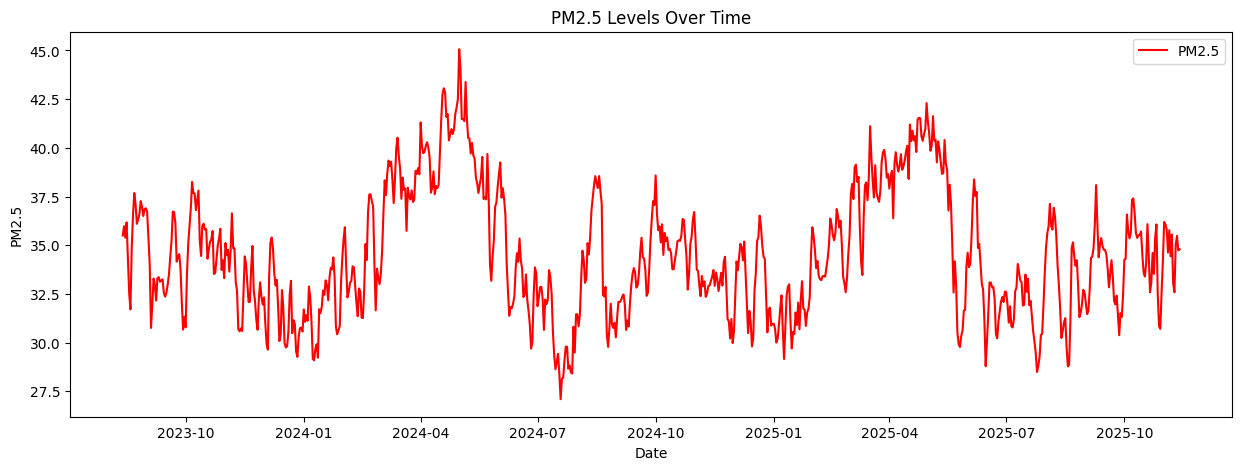

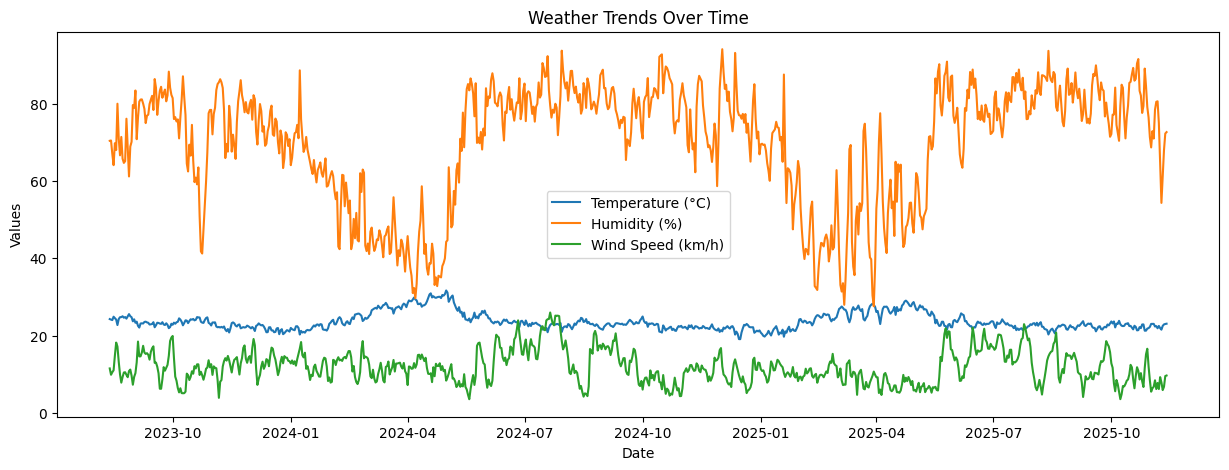

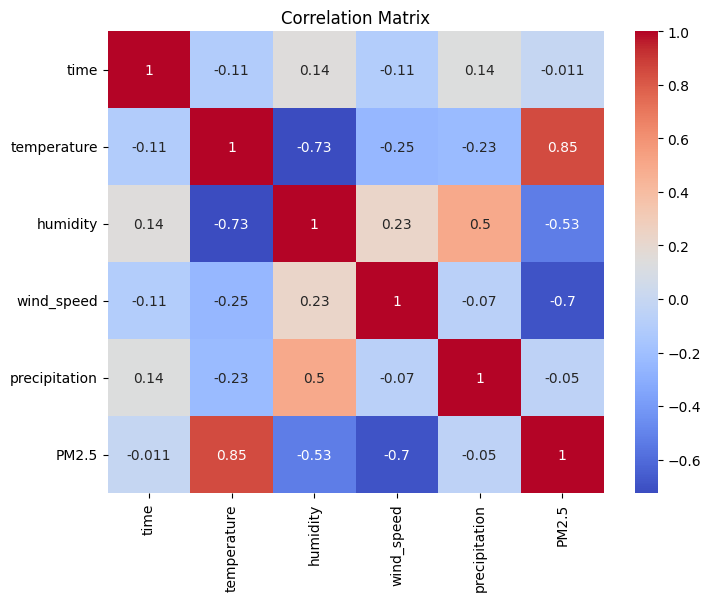

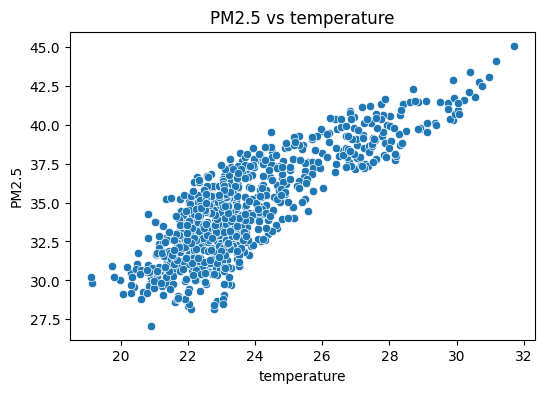

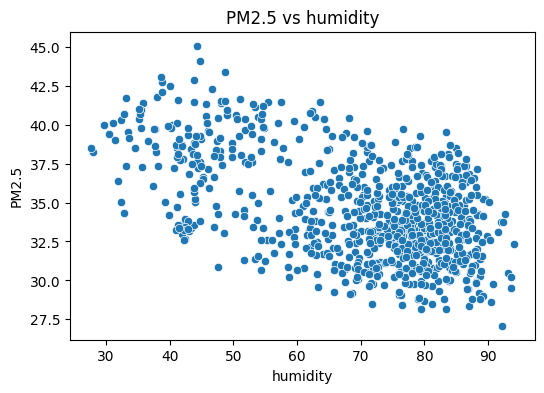

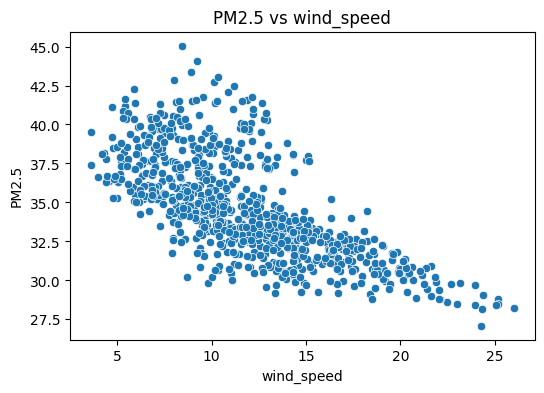

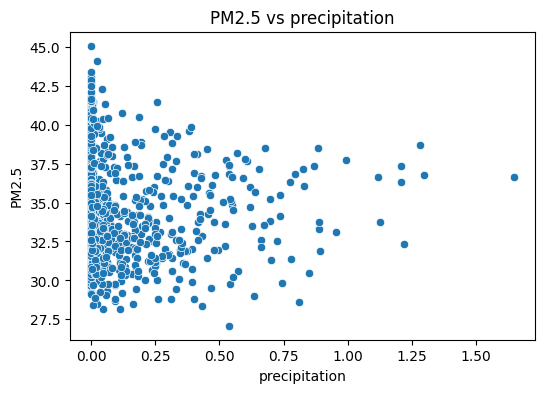

C:\Users\rayya\AppData\Local\Temp\ipykernel_1592\26718832.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_pm25.index, y=monthly_pm25.values, palette='OrRd')


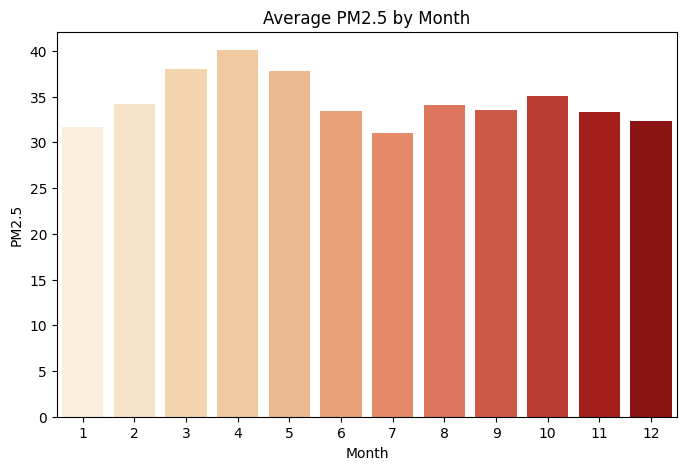

 Clean dataset saved as Bangalore_weather_pm25_clean.csv


In [5]:

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])
print("Dataset shape:", df.shape)
print(df.head())

print("\n=== Descriptive Statistics ===")
print(df.describe())

# Check missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())


plt.figure(figsize=(15,5))
plt.plot(df['time'], df['PM2.5'], color='red', label='PM2.5')
plt.title("PM2.5 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.show()

# Weather trends
plt.figure(figsize=(15,5))
plt.plot(df['time'], df['temperature'], label='Temperature (°C)')
plt.plot(df['time'], df['humidity'], label='Humidity (%)')
plt.plot(df['time'], df['wind_speed'], label='Wind Speed (km/h)')
plt.title("Weather Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


features = ['temperature', 'humidity', 'wind_speed', 'precipitation']
for f in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[f], y=df['PM2.5'])
    plt.title(f"PM2.5 vs {f}")
    plt.show()

df['month'] = df['time'].dt.month
monthly_pm25 = df.groupby('month')['PM2.5'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=monthly_pm25.index, y=monthly_pm25.values, palette='OrRd')
plt.title("Average PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

df.to_csv("Bangalore_weather_pm25_clean.csv", index=False)
print(" Clean dataset saved as Bangalore_weather_pm25_clean.csv")


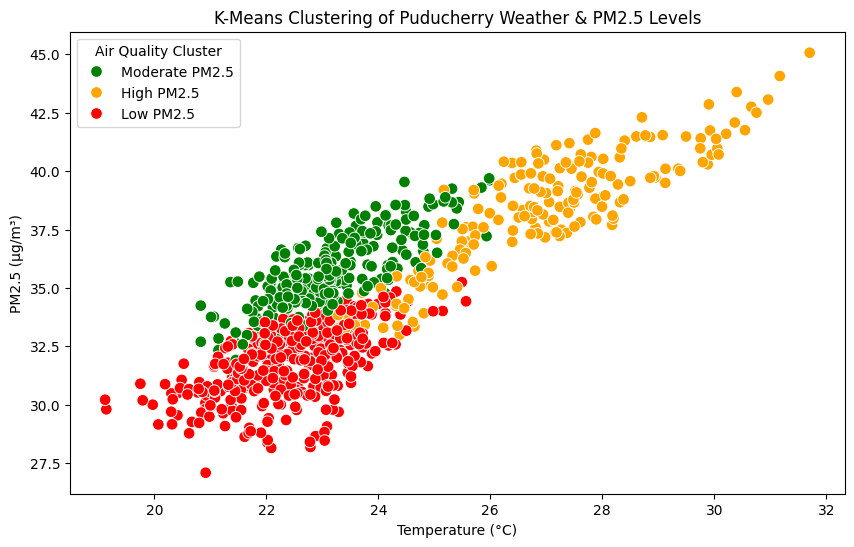

Cluster summary by PM2.5 levels:
                 temperature   humidity  wind_speed  precipitation      PM2.5
cluster_label                                                               
High PM2.5        26.900789  47.245395    9.987237       0.011206  38.338401
Low PM2.5         22.409302  75.986865   15.184087       0.102401  31.857801
Moderate PM2.5    23.148026  78.193151    8.371053       0.239575  35.653671


In [6]:
# =============================
# K-MEANS CLUSTERING (UPDATED)
# =============================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])

# Select features for clustering
features = ['temperature', 'humidity', 'wind_speed', 'precipitation', 'PM2.5']
X = df[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Create a cluster summary to assign labels
cluster_summary = df.groupby('cluster')['PM2.5'].mean().sort_values()
labels = {}
labels[cluster_summary.index[0]] = 'Low PM2.5'
labels[cluster_summary.index[1]] = 'Moderate PM2.5'
labels[cluster_summary.index[2]] = 'High PM2.5'

# Map cluster numbers to readable labels
df['cluster_label'] = df['cluster'].map(labels)

# Scatter plot with labeled clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='temperature',
    y='PM2.5',
    hue='cluster_label',
    palette=['green', 'orange', 'red'],
    s=70
)
plt.title("K-Means Clustering of Puducherry Weather & PM2.5 Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend(title='Air Quality Cluster')
plt.show()

# Optional: Print cluster summary
print("Cluster summary by PM2.5 levels:\n", df.groupby('cluster_label')[features].mean())


 Data shape: (824, 6)
        time  temperature   humidity  wind_speed  precipitation      PM2.5
0 2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1 2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2 2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3 2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4 2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833


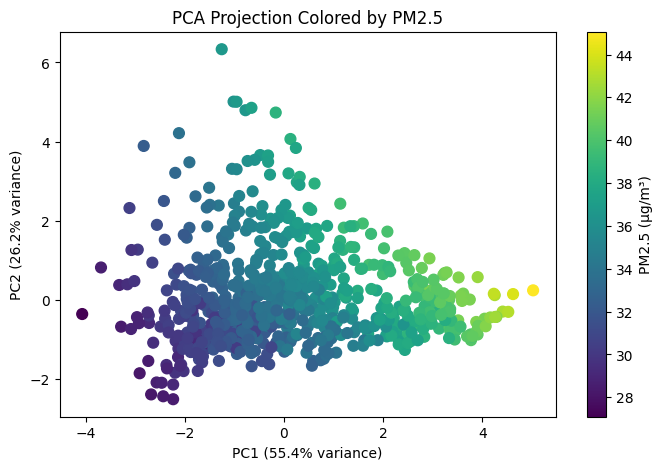

In [7]:
# PCA Notebook: Weather + PM2.5
# ======================================================

#  Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ======================================================
#  Load Data
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])
print(" Data shape:", df.shape)
print(df.head())

# ======================================================
#  Prepare Data for PCA
features = ['temperature','humidity','wind_speed','precipitation','PM2.5']
X = df[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================================
#  PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
df['PC1'] = pcs[:,0]
df['PC2'] = pcs[:,1]

# ======================================================
# PCA Scatter Plot (Colored by PM2.5)
plt.figure(figsize=(8,5))
sc = plt.scatter(df['PC1'], df['PC2'], c=df['PM2.5'], cmap='viridis', s=60)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("PCA Projection Colored by PM2.5")
plt.colorbar(sc, label='PM2.5 (µg/m³)')
plt.show()



 Data shape: (824, 6)
        time  temperature   humidity  wind_speed  precipitation      PM2.5
0 2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1 2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2 2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3 2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4 2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833
Mean Squared Error: 0.08
R² Score: 0.98


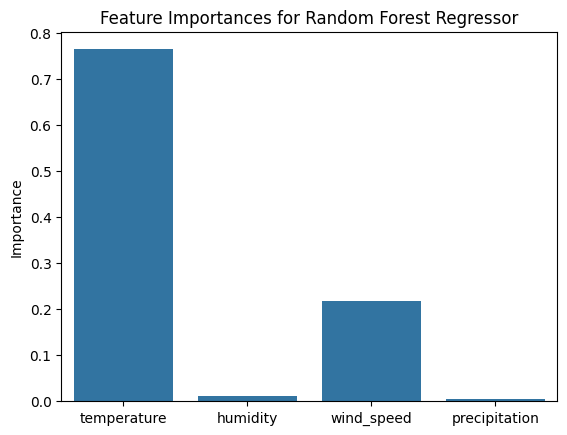

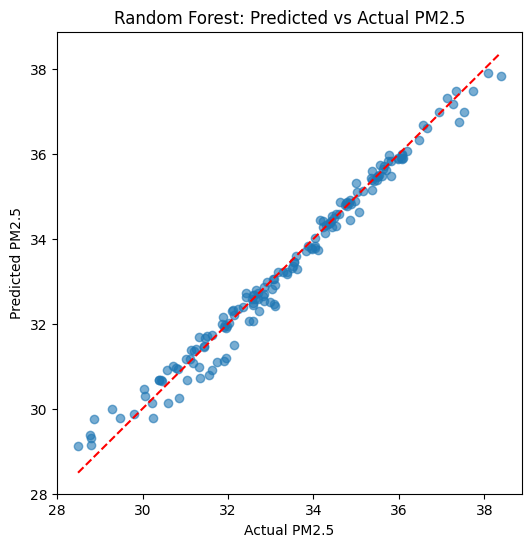

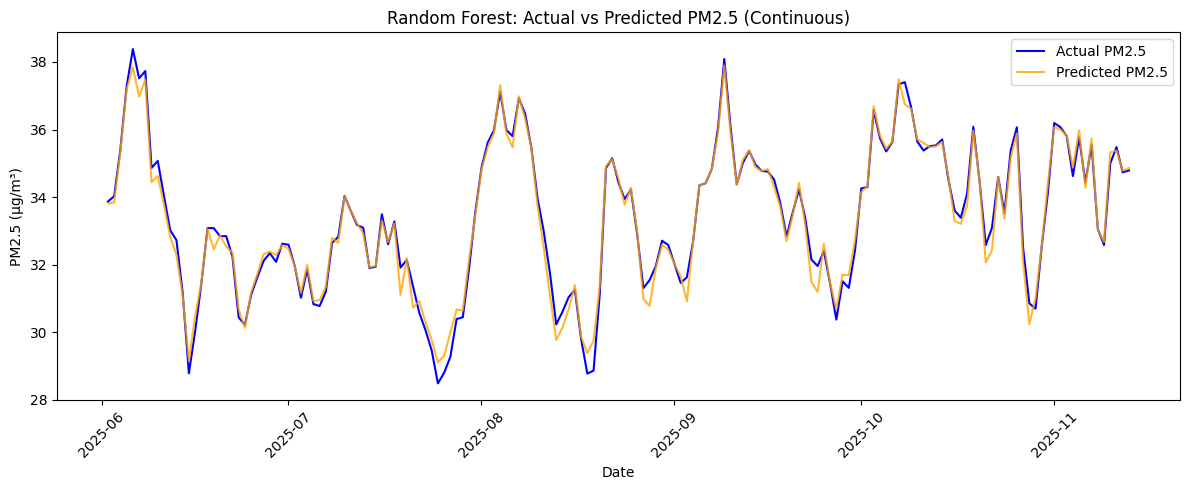

In [8]:
# Random Forest Regression Notebook: PM2.5 Prediction
# ======================================================

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ======================================================
# Load Data
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])
print(" Data shape:", df.shape)
print(df.head())

# ======================================================
#  Prepare Features & Target
features = ['temperature','humidity','wind_speed','precipitation']
target = 'PM2.5'

X = df[features]
y = df[target]

# Train-test split (keeping time order for continuous plotting)
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(
    X, y, df['time'], test_size=0.2, shuffle=False
)

# ======================================================
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# ======================================================
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# ======================================================
# Feature Importance Plot
importances = rf.feature_importances_
sns.barplot(x=features, y=importances)
plt.title("Feature Importances for Random Forest Regressor")
plt.ylabel("Importance")
plt.show()

# ======================================================
# Predicted vs Actual Scatter Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Random Forest: Predicted vs Actual PM2.5")
plt.show()

# ======================================================
# Continuous Graph: Actual vs Predicted PM2.5 Over Time
plt.figure(figsize=(12,5))
plt.plot(time_test, y_test, label='Actual PM2.5', color='blue')
plt.plot(time_test, y_pred, label='Predicted PM2.5', color='orange', alpha=0.8)
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Random Forest: Actual vs Predicted PM2.5 (Continuous)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Data shape: (824, 6)
        time  temperature   humidity  wind_speed  precipitation      PM2.5
0 2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1 2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2 2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3 2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4 2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833
X_seq shape: (817, 7, 4)
y_seq shape: (817, 1)


c:\AI_ML\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0370 - val_loss: 0.0123
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0159 - val_loss: 0.0102
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0139 - val_loss: 0.0181
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0148 - val_loss: 0.0093
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138 - val_loss: 0.0086
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - val_loss: 0.0084
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0103
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0068
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.008

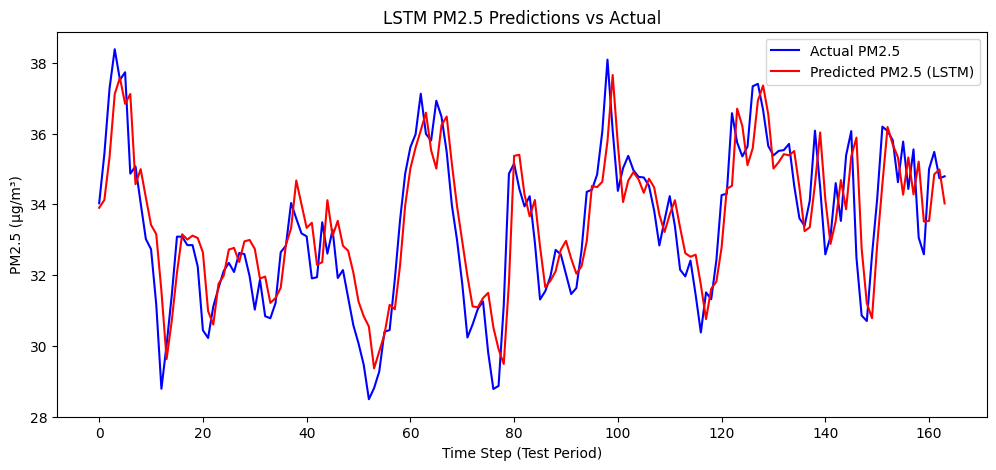

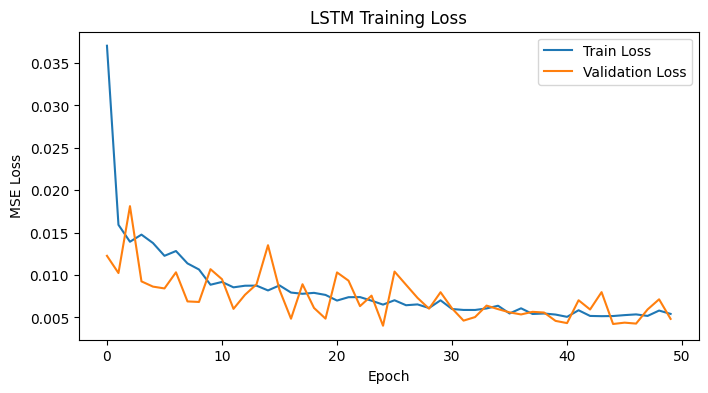

In [10]:
# ============================================
# LSTM for PM2.5 Prediction
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# ============================================
# Load Data
# ============================================
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])
df = df.sort_values("time")
print(" Data shape:", df.shape)
print(df.head())

# ============================================
# Feature Selection and Scaling
# ============================================
features = ['temperature', 'humidity', 'wind_speed', 'precipitation']
target = 'PM2.5'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# ============================================
# Create Time-Series Sequences
# ============================================
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7  # use past 7 days to predict next day
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

# ============================================
# Train-Test Split (time-based)
# ============================================
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ============================================
# Build LSTM Model
# ============================================
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ============================================
# Train Model
# ============================================
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# ============================================
# Evaluate on Test Set
# ============================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mean_pm25 = np.mean(y_true)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean PM2.5 Value (Actual): {mean_pm25:.2f} µg/m³")

# ============================================
# Plot Actual vs Predicted PM2.5
# ============================================
plt.figure(figsize=(12,5))
plt.plot(range(len(y_true)), y_true, label='Actual PM2.5', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted PM2.5 (LSTM)', color='red')
plt.xlabel("Time Step (Test Period)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("LSTM PM2.5 Predictions vs Actual")
plt.legend()
plt.show()

# ============================================
# Plot Training Loss
# ============================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [11]:
# Number of rows in the dataset
num_rows = df.shape[0]
print(f"Number of rows in the dataset: {num_rows}")


Number of rows in the dataset: 824


In [12]:
# ============================================
# Sort the dataset by time
# ============================================
df_sorted = df.sort_values(by="time").reset_index(drop=True)

# Display first 20 rows
print("First 20 rows:")
print(df_sorted.head(20))

# Display last 20 rows
print("\nLast 20 rows:")
print(df_sorted.tail(20))

# Optional: number of rows
print(f"\nTotal number of rows: {df_sorted.shape[0]}")


First 20 rows:
         time  temperature   humidity  wind_speed  precipitation      PM2.5
0  2023-08-13    24.312500  70.375000   11.558333       0.008333  35.501667
1  2023-08-14    24.170833  70.458333    9.925000       0.012500  35.975000
2  2023-08-15    24.054167  66.958333   10.579167       0.020833  35.386667
3  2023-08-16    24.925000  64.083333   11.083333       0.000000  36.173333
4  2023-08-17    24.533333  69.750000   14.875000       0.025000  34.430833
5  2023-08-18    24.183333  68.000000   18.245833       0.045833  32.540000
6  2023-08-19    22.766667  79.958333   17.220833       0.304167  31.706250
7  2023-08-20    24.320833  70.958333   13.295833       0.033333  34.846667
8  2023-08-21    24.804167  66.625000   10.012500       0.000000  36.571667
9  2023-08-22    24.820833  71.375000    7.883333       0.033333  37.682500
10 2023-08-23    25.041667  65.750000    9.350000       0.000000  37.101667
11 2023-08-24    24.666667  64.666667   10.508333       0.000000  36.0966

c:\AI_ML\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 64)          │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,881 (89.38 KB)

 Trainable params: 22,881 (89.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0416 - val_loss: 0.0097
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - val_loss: 0.0081
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0109 - val_loss: 0.0064
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100 - val_loss: 0.0045
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0048
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

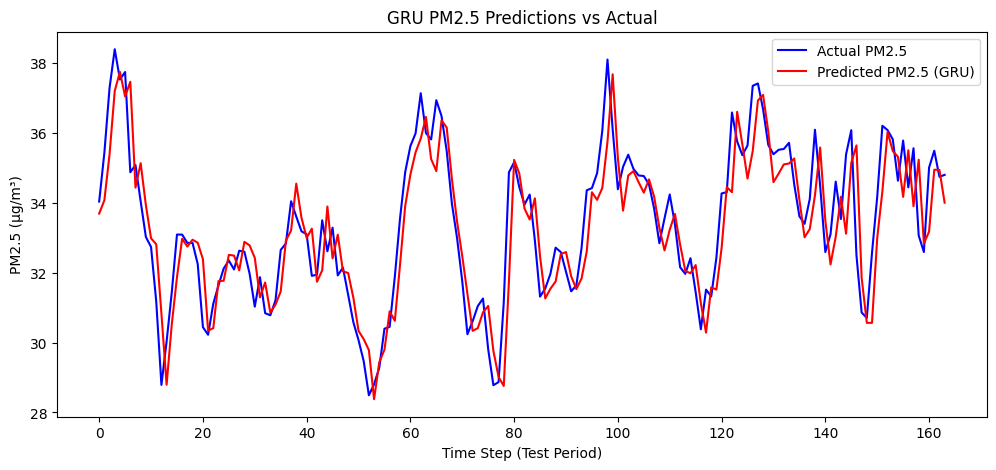

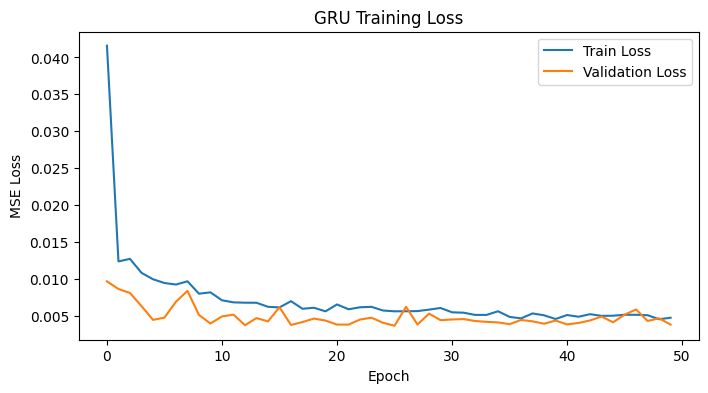

In [13]:
# ============================================
# GRU for PM2.5 Prediction
# ============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ============================================
# Load and prepare data
# ============================================
df = pd.read_csv("Bangalore_weather_pm25.csv", parse_dates=["time"])
df = df.sort_values("time")

features = ['temperature', 'humidity', 'wind_speed', 'precipitation']
target = 'PM2.5'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# ============================================
# Create sequences
# ============================================
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# ============================================
# Train-test split
# ============================================
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ============================================
# Build GRU Model
# ============================================
model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ============================================
# Train Model
# ============================================
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# ============================================
# Evaluate on Test Set
# ============================================
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mean_pm25 = np.mean(y_true)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean PM2.5 Value: {mean_pm25:.2f} µg/m³")

# ============================================
# Plot Actual vs Predicted
# ============================================
plt.figure(figsize=(12,5))
plt.plot(range(len(y_true)), y_true, label='Actual PM2.5', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted PM2.5 (GRU)', color='red')
plt.xlabel("Time Step (Test Period)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("GRU PM2.5 Predictions vs Actual")
plt.legend()
plt.show()

# ============================================
# Plot Training Loss
# ============================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("GRU Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


c:\AI_ML\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU model...
GRU model trained successfully!


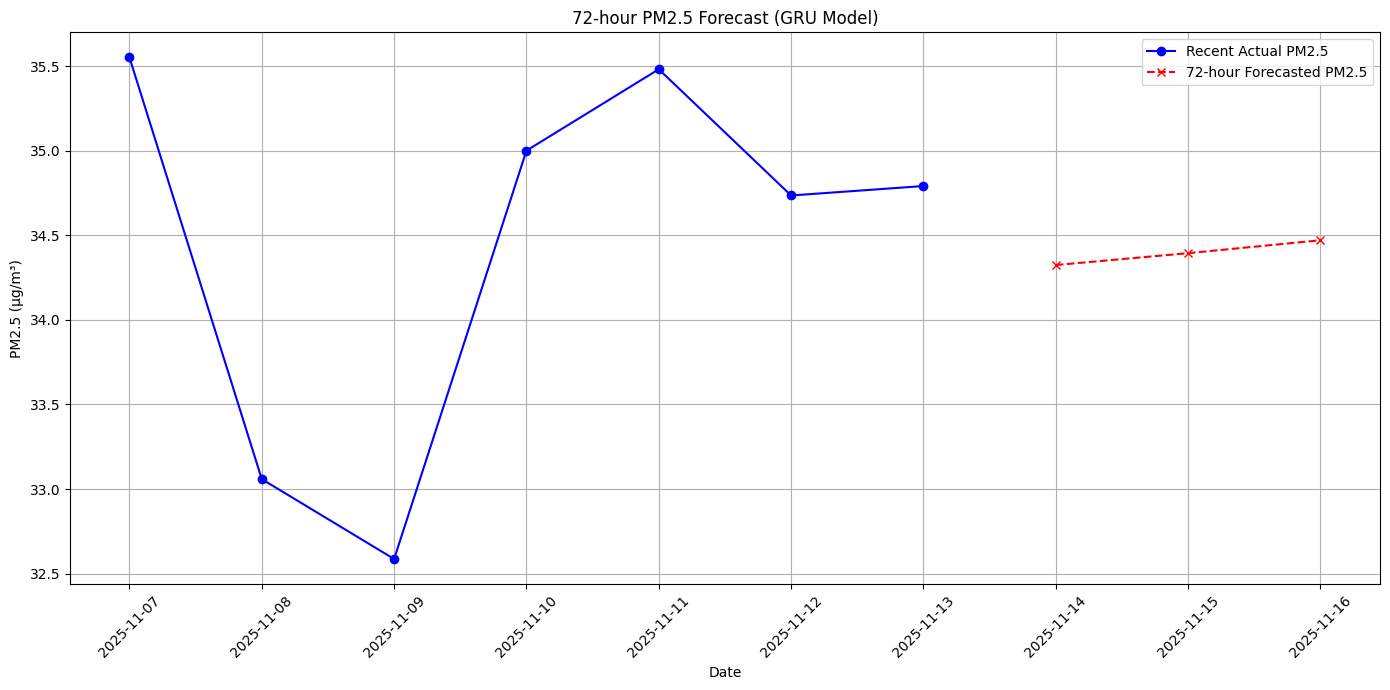


 72-hour PM2.5 forecast generated successfully!

Forecasted PM2.5 values for the next 72 hours:
  2025-11-14: 34.32 µg/m³
  2025-11-15: 34.39 µg/m³
  2025-11-16: 34.47 µg/m³


In [15]:
# ============================================
# 72-hour (3-day) PM2.5 Forecasting using GRU Model
# ============================================

# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# ============================================
# Load and Prepare Dataset
# ============================================

# Read CSV file (ensure 'Bangalore_weather_pm25.csv' is in your working directory)
df = pd.read_csv("Bangalore_weather_pm25_clean.csv", parse_dates=["time"])
df = df.sort_values("time").reset_index(drop=True)

# Select features and target column
features = ['temperature', 'humidity', 'wind_speed', 'precipitation']
target = 'PM2.5'

# Initialize and fit scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled_all = scaler_X.fit_transform(df[features])
y_scaled_all = scaler_y.fit_transform(df[[target]])

# ============================================
# Create Sequences for GRU Input
# ============================================

def create_sequences(X, y, time_steps=7):
    """
    Convert time series data into sequences of shape (time_steps, features)
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled_all, y_scaled_all, time_steps)

# Split into training and testing sets (80/20)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ============================================
# Build and Train the GRU Model
# ============================================

model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

print("Training GRU model...")
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)
print("GRU model trained successfully!")

# ============================================
# Prepare Data for 72-hour Forecast
# ============================================

# Take last 'time_steps' days of actual data
last_sequence_data_X = X_scaled_all[-time_steps:]
last_sequence_data_y = y_scaled_all[-time_steps:]

# Create future dates (next 3 days)
last_date = df['time'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='D')

# Simulate future weather — Option A: repeat last day (simple)
# last_weather_features = df[features].iloc[-1].values
# simulated_future_weather = pd.DataFrame([last_weather_features] * 3, columns=features)

# Option B (Recommended): add small random variations for realism
last_weather_features = df[features].iloc[-1].values
simulated_future_weather = pd.DataFrame(
    [last_weather_features + np.random.normal(0, 0.02, size=len(features)) for _ in range(3)],
    columns=features
)

# Scale the simulated weather data
simulated_future_weather_scaled = scaler_X.transform(simulated_future_weather)

# ============================================
# Generate Forecast Iteratively (Auto-regressive Style)
# ============================================

forecasted_pm25_scaled = []
current_input_sequence = last_sequence_data_X.copy()

for i in range(3):  # Forecast next 3 days (72 hours)
    # Reshape input for GRU
    model_input = current_input_sequence.reshape(1, time_steps, len(features))

    # Predict next PM2.5 (scaled)
    next_pm25_scaled = model.predict(model_input, verbose=0)[0]
    forecasted_pm25_scaled.append(next_pm25_scaled)

    # Prepare next sequence input (shift window)
    new_day_features = simulated_future_weather_scaled[i]
    current_input_sequence = np.vstack([current_input_sequence[1:], new_day_features])

# Inverse scale forecasted PM2.5
forecasted_pm25 = scaler_y.inverse_transform(np.array(forecasted_pm25_scaled).reshape(-1, 1))

# ============================================
# Visualize Actual vs Forecasted PM2.5
# ============================================

# Get recent actual PM2.5 for comparison
actual_pm25_display = df[target].tail(time_steps).values
actual_dates_display = df['time'].tail(time_steps)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(actual_dates_display, actual_pm25_display, label='Recent Actual PM2.5', color='blue', marker='o')
plt.plot(future_dates, forecasted_pm25, label='72-hour Forecasted PM2.5', color='red', linestyle='--', marker='x')

plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('72-hour PM2.5 Forecast (GRU Model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================
# Print Forecasted Values
# ============================================

print("\n 72-hour PM2.5 forecast generated successfully!\n")
print("Forecasted PM2.5 values for the next 72 hours:")
for date, value in zip(future_dates, forecasted_pm25):
    print(f"  {date.strftime('%Y-%m-%d')}: {value[0]:.2f} µg/m³")
